In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os

import utils.datasets as datasets
import utils.sde_lib as sdes
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 1000
# covs = torch.tensor([[[3., -1.],[-1., 2.]], [[3., 1.8],[1.8, 2.]], [[3., -1.],[-1., 2.]]], device=device)
# means = torch.tensor([[0,3.], [10,5.], [-6.,0]],device=device)
# weights = torch.ones(means.shape[0],device=device)/means.shape[0]
# gmm = GMM(weights,means,covs)
dataset = datasets.get_dataset(dotdict({'dataset' : 'spiral'}))
data = dataset.sample(5).to(device=device)

sde = sdes.LinearSchrodingerBridge(2,device)
model = MLP(2,False).to(device=device)

eps = sde.delta
times = (torch.rand((data.shape[0]),device=data.device) * (1-eps) + eps) * sde.T()
shaped_t = times.reshape(-1,1,1,1) if len(data.shape) > 2 else times.reshape(-1,1)
# mean, L, invL, _ = sde.marginal_prob(data,shaped_t)
# noise = torch.randn_like(mean,device=data.device)
# perturbed_data = mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
# flatten_error = ((torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1) + model(perturbed_data,times))**2).view(data.shape[0],-1)


# std = (1-torch.exp(-sde.beta_int(shaped_t)))**.5

# print(times)
# print((std).cpu().numpy())
# print(L[:,0,0].cpu().numpy())

# print(L)
# print(invL.mT)

# print(perturbed_data)
# print(torch.exp(-sde.beta_int(shaped_t)/2) * data + noise * std)

# print(torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1))
# print(noise / std)

# plt.scatter(data[:,0], data[:,1])
# plt.show()


# print(-.5 * sde.beta(shaped_t) * perturbed_data)
# print(-.5 * sde.beta(shaped_t) * batch_matrix_product(sde.A(shaped_t),perturbed_data))
# print(sde.drift(perturbed_data,shaped_t))


tensor([[ 0.200,  0.866],
        [-0.652, -0.753]], grad_fn=<ViewBackward0>)


In [3]:
t = shaped_t
int_mat = sde.int_beta_ds(t)
print(int_mat)
dim = int_mat.shape[-1]
C_H_power = torch.zeros((t.shape[0], 2 * dim, 2 * dim),device=int_mat.device)
C_H_pair = torch.zeros_like(C_H_power)
C_H_power[:,:dim, :dim] = -.5 * int_mat
C_H_power[:,-dim:, -dim:] = .5 * int_mat
C_H_power[:, :dim, dim:] = sde.beta_int(t).view(-1,1,1) * torch.eye(dim,device=int_mat.device).unsqueeze(0).expand(t.shape[0],-1,-1)


print(C_H_power)
C_H_pair = torch.linalg.matrix_exp(C_H_power)
initial_cond = torch.cat((torch.zeros((dim,dim), device=int_mat.device), torch.eye(dim,device=int_mat.device)), dim=0)
C_H = torch.einsum('tij,jk->tik', C_H_pair, initial_cond)
C = C_H[:, : dim, :]
H = C_H[:, dim: , :]
cov = torch.einsum('tij,tjk->tik', C, torch.linalg.inv(H))
L = torch.linalg.cholesky(cov)
invL = torch.linalg.inv(L.mH)
print(C_H_pair)

tensor([[[ 8.691,  6.370],
         [ 6.370, 22.220]],

        [[ 0.203,  0.023],
         [ 0.023,  1.286]],

        [[ 0.256,  0.043],
         [ 0.043,  1.536]],

        [[ 0.552,  0.185],
         [ 0.185,  2.754]],

        [[ 0.775,  0.310],
         [ 0.310,  3.557]]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[ -4.346,  -3.185,   4.292,   0.000],
         [ -3.185, -11.110,   0.000,   4.292],
         [  0.000,   0.000,   4.346,   3.185],
         [  0.000,   0.000,   3.185,  11.110]],

        [[ -0.101,  -0.012,   0.298,   0.000],
         [ -0.012,  -0.643,   0.000,   0.298],
         [  0.000,   0.000,   0.101,   0.012],
         [  0.000,   0.000,   0.012,   0.643]],

        [[ -0.128,  -0.022,   0.354,   0.000],
         [ -0.022,  -0.768,   0.000,   0.354],
         [  0.000,   0.000,   0.128,   0.022],
         [  0.000,   0.000,   0.022,   0.768]],

        [[ -0.276,  -0.093,   0.619,   0.000],
         [ -0.093,  -1.377,   0.000,   0.619],
         [  0.0

In [4]:
ts = torch.linspace(.1,sde.T(), 6,device=device).unsqueeze(-1)
cov, L, invL, _ = sde.compute_variance(ts)
print(L)
print(invL)

tensor([[[     0.223,      0.001],
         [     0.001,      0.213]],

        [[     0.583,     -0.006],
         [    -0.006,      0.434]],

        [[     0.796,     -0.049],
         [    -0.049,      0.469]],

        [[     0.838,     -0.098],
         [    -0.098,      0.470]],

        [[     0.803,     -0.130],
         [    -0.130,      0.472]],

        [[     0.760,     -0.151],
         [    -0.151,      0.474]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)
tensor([[[ 4.494, -0.012],
         [-0.012,  4.705]],

        [[ 1.716,  0.025],
         [ 0.025,  2.307]],

        [[ 1.265,  0.132],
         [ 0.132,  2.148]],

        [[ 1.223,  0.255],
         [ 0.255,  2.181]],

        [[ 1.303,  0.358],
         [ 0.358,  2.217]],

        [[ 1.404,  0.448],
         [ 0.448,  2.251]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)


In [5]:
A = torch.tensor([[ 0.9150,  0.8235],[-0.9749,  0.3197]],device=device)
D = torch.eye(2,device=device) - 2  * (A + A.T)

print(D)
print(torch.linalg.eigh(D))
# print(sde.compute_variance(torch.tensor([[sde.T()]],device=device)))

tensor([[-2.660,  0.303],
        [ 0.303, -0.279]], device='cuda:0')
torch.return_types.linalg_eigh(
eigenvalues=tensor([-2.698, -0.241], device='cuda:0'),
eigenvectors=tensor([[ 0.992,  0.124],
        [-0.124,  0.992]], device='cuda:0'))


In [6]:
model_path = './checkpoints/spiral_sb_linear/itr_2000'
forward_score = torch.load(os.path.join(model_path,'forward_ema_2000.pt'))
backward_score = torch.load(os.path.join(model_path,'backward_ema_2000.pt'))

sde = sdes.SchrodingerBridge(forward_score,backward_score)

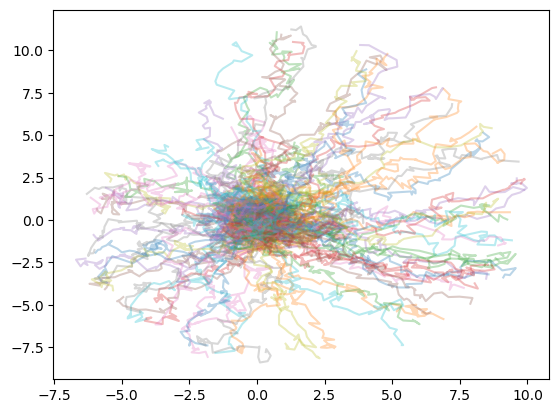

In [11]:
dataset = datasets.Spiral()
n_samples = 100
in_cond = dataset.sample(n_samples).to(device=device)
xt, traj = sde.sample((n_samples,2), device, backward=True, in_cond=in_cond, prob_flow=False)

# for i in range(traj.shape[1]):
#     xi = traj[:,i]
    
#     plt.xlim([-16,16])
#     plt.ylim([-16,16])
#     plt.scatter(xi[:,0].cpu(), xi[:,1].cpu())
#     plt.savefig(f'./trajectory/{i}.png')
#     plt.clf()

for i in range(traj.shape[0]):
    xi = traj[i]
    plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), alpha=.3)
plt.show()